# Playing with TTE Data

Unfortuantely, there are not built in ways to arbitraily bin data with RMFIT. Therefore, we must make our own. Here we will see how to:
- Open GBM TTE files
- Make energy selections 
- Bin the data with various methods




In [1]:
import astropy.io.fits as fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
tteFile = fits.open("glg_tte_n0_bn080916009_v01.fit")

# Select the EBOUNDS extension 
# This extension allows us to map
# energy into channel number
ebounds = tteFile["EBOUNDS"]

# The events extension is where the time
# and energy tags are stored
events  = tteFile["EVENTS"]

# We will also need the trigger time
# which we grab from the primary
# header file
trigTime = tteFile[0].header["TRIGTIME "]


TTE events are tagged in time and PHA channel number. It is important fro us to be able to make selections on energy when binning data with various methods. For example, we do not want to include overflow channels when creating Bayesian blocks. Or, we may be interested in the variability of the 30-40 keV range and chose to bin from there.


Therefore we must write some functions to properly select events by channel. Then we must right a function that selects events over a particular energy range.

In [3]:
def Energy2Channel(energy,ebounds):
    
    # Find which channel contains the energy you select
    index = ebounds.data["E_MAX"].searchsorted(energy)
    return ebounds.data["CHANNEL"][index]


def SelectEvents(emin,emax,ebounds,events):
    
    # Obatain or maximum and minimum channels
    chanMax = Energy2Channel(emax,ebounds)
    chanMin = Energy2Channel(emin,ebounds)
    
    
    # Make a logical selection on the data
    
    greaterTruthTable = events.data["PHA"] >= chanMin
    lesserTruthTable  = events.data["PHA"] <= chanMax
    
    combinedSelection = greaterTruthTable & lesserTruthTable
    
    # Return the events selection in trigger time
    return events.data["TIME"][combinedSelection] - trigTime
    
    
    

With these two functions, we can easily select events that are between two energies. **Try and make similar functions that allow you too select non-contiguous regions in energy space.** These types of functions are easily integrated into classes that allow for nice clean operation of TTE files.


# Binning data

Now let's actaully bin the data. First we will select some events from the NaI we loaded above. We choose the sweet spot of the detector (8-300 keV) for binning.

In [4]:
selectedEvents = SelectEvents(8.,300.,ebounds,events)

The library astroML has some very nice utilities for binning data. We will use it here to bin the events.

In [5]:
from astroML.density_estimation import bayesian_blocks, knuth_bin_width

Some of these algorithms take a long time to run. We are only interested in the events around the source (unless we believe there is something else off-source). Therefore, we use numpy to select events around the source time.

In [6]:
timeSelectedEvents = selectedEvents[(selectedEvents>=-1.) & (selectedEvents<=72.) ]

In [60]:
bb = bayesian_blocks(timeSelectedEvents,p0=0.05)

(array([ 0.00757724,  0.01287145,  0.00256339,  0.01149585,  0.01476928,
         0.01915651,  0.23048999,  0.01777719,  0.01518724,  0.10786262,
         0.01419023,  0.01874876,  0.01363137,  0.04276961,  0.01450479,
         0.01553554,  0.01395919,  0.01295626,  0.01168701,  0.04875434,
         0.01107698,  0.01301815,  0.01130138,  0.01333201,  0.04612093,
         0.01151899]),
 array([ -0.998548  ,  -0.97569299,  -0.94482699,  -0.93290499,
          0.18274501,   0.903521  ,   4.82109801,   4.821319  ,
          6.78224002,  10.17492402,  10.17577401,  13.62089701,
         13.75075501,  16.63987501,  16.645115  ,  20.22060101,
         26.386316  ,  38.63615701,  48.809513  ,  50.99298501,
         50.996746  ,  56.22218901,  60.03304802,  62.34060101,
         63.61740501,  63.620939  ,  71.99936402]),
 <a list of 26 Patch objects>)

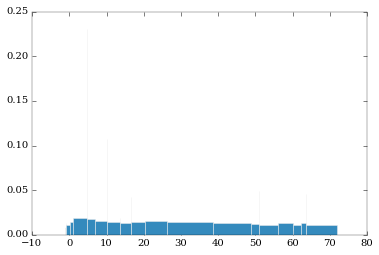

In [59]:
_,_,_ = hist(timeSelectedEvents,bins=bb,normed=True,histtype="step",color='k')

Optimization terminated successfully.
         Current function value: -808.284842
         Iterations: 16
         Function evaluations: 44


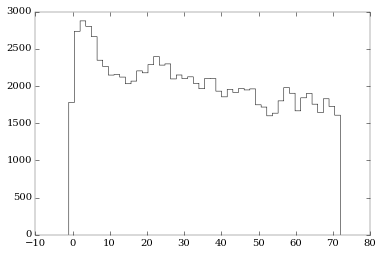

In [13]:
knWidth = knuth_bin_width(timeSelectedEvents)
_,_,_ = hist(timeSelectedEvents,bins=arange(-1.,72.,knWidth),histtype="step",color='k')

There is an included tool to help with binning. It is still in alpha stage but can be used to bin TTE data easily and 
make GBM .ti files for custom binning. 

In [14]:
from spectralTools.binning.tteBinning import tteBinning

The Trigger Time for this event::
243216766.613542
Optimization terminated successfully.
         Current function value: -844.321976
         Iterations: 17
         Function evaluations: 47


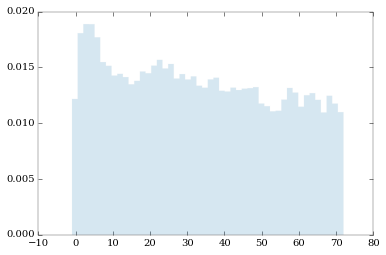

In [19]:
# Load a TTE file and set the start and stop times
tb = tteBinning("glg_tte_n0_bn080916009_v01.fit",-1,72.)
# Select a method to bin the data
tb.MakeKnuth()

# Can print out the plot
tb.Preview()

# Write ti files to a sub-folder
tb.MakeTI()